## Code using NLP to predict which tweets are about natural disasters.

### - Import modules -

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import re
import string

#### Read in the data

In [2]:
all_train_data = pd.read_csv('train.csv')
shuffled_all_train_data = all_train_data.sample(frac = 1)

### - Analyse and tidy the data -

In [3]:
print(all_train_data.head())
print(all_train_data['target'].value_counts(normalize = True))

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
0    0.57034
1    0.42966
Name: target, dtype: float64


#### Split the data into sentences and labels
Note there is also a keyword and location field that can be used but might be blank. For now, I stick with the completed data - so the tweet is the only feature used.

In [4]:
sentences = shuffled_all_train_data['text'].tolist()
labels = shuffled_all_train_data['target'].tolist()

#### Look at some examples of tweets and their labels

In [5]:
print("data length = ", len(sentences))
print(sentences[:10])
print(labels[:10])

data length =  7613
['?#FUKUSHIMA?#TEPCO?\nFukushima Nuclear Disaster | Increased Thyroid Cancer in #US - Integrative Cancer Answers\nhttp://t.co/7Y2GNVA2eV', '@BrrookkllyynnR came through like a tornado and destroyed me. such beautiful words', "Please allow me to reiterate it's not the weapon it's the mindset of the individual! #professional #help! -LEGION! https://t.co/2lGTZkwMqW", "Check out 'Malaysia Confirms Plane Wreckage Is From Flight MH370' at  http://t.co/UB3woZ2UT1", 'Deals : http://t.co/ddhWoRI5w1 #37592 Temporary Fake Tooth Teeth Replacement Kit Emergency Dental Oral Care Cosme\x89Û_ http://t.co/ZCvfC500yY', "Man why hasn't @machinegunkelly blown up? He's still underground.", "Families to sue over Legionnaires' disease outbreak in Edinburgh - BBC News http://t.co/rM6CNzkSzL", "RT to ruin @connormidd 's day.  http://t.co/krsy54XMMC", "@matt_bez oh I'm not bagging her at all! Her body be bangin'. I'm saying she's going to get the rose.", '#Bestnaijamade: 16yr old PKK suicide

#### Look at length of tweets in terms of number of characters

In [6]:
max = 0
for sentence in sentences:
    length = len(sentence)
    if length > max:
        max = length
        print(max)
        print(sentence)

print("Max length = ", max)

132
?#FUKUSHIMA?#TEPCO?
Fukushima Nuclear Disaster | Increased Thyroid Cancer in #US - Integrative Cancer Answers
http://t.co/7Y2GNVA2eV
138
Please allow me to reiterate it's not the weapon it's the mindset of the individual! #professional #help! -LEGION! https://t.co/2lGTZkwMqW
139
Deals : http://t.co/ddhWoRI5w1 #37592 Temporary Fake Tooth Teeth Replacement Kit Emergency Dental Oral Care CosmeÛ_ http://t.co/ZCvfC500yY
140
#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_
142
@BarackObama Senator John McCainÛªs Whoops Moment : Photographed Chilling With ISISÛ_ http://t.co/JNrOMsE1Z2 @acmilan http://t.co/w6Yu7Qs4CV
147
Savs contact fell out but she was convinced it didnt &amp; went on to guage her eyeball out &amp; now shes having a panic attack over caused damage
157
when you're taking a shower and someone flushes the toilet and you have .1 second to GTFO or you get burned?????????????????????

### - Tokenize the words -
We now tokenize the 100 most common words by assigning them a number and then turning the tweets into sequences to train the model. In the model, we have an embedding dimension which assigns a vector for each word and allows words with similar meanings to appear close in the embedding parameter space, e.g., words that are negative in sentiment would have similar vectors.

We can see from example data that many tweets have URLs, user names, hashtags and numbers.
We could process these to tidy the data - however, unless we create additional features to train the model, 
then there is no point pre-processing as the tokenizer will simply replace these values with an out-of-value token.

In [7]:
## Tokenize most 1000 common words
vocab_size = 1000 

## Embedding dimension size
embedding_size = 6

## Where to truncate tweets that are too long (won't be needed)
trunc_type = 'post' 

## Where to pad tweets that are too long
padding_type = 'post'

## Token used for words outside of vocab which get tokenized as 1 (check this)
oov_tok = '<OOV>' 

#### Initialise the tokenizer

In [8]:
tokeniser = Tokenizer(num_words = vocab_size, 
                      oov_token = oov_tok,
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{"}~\t\n|', ## by default, all punctuation is filtered
                      lower=True, ## Make tweets all lowercase
                      split = ' ',) 

In [9]:
## tokenise the words
tokeniser.fit_on_texts(sentences) 

## Extract the word index
word_index = tokeniser.word_index 

#### Look at the words that have been tokenised.

In [10]:
print("{:<15} {:<10}".format('Label','Number'))
for k, v in word_index.items():
    label = k
    num = v
    print("{:<15} {:<10}".format(label, num))

Label           Number    
<OOV>           1         
t               2         
co              3         
http            4         
the             5         
a               6         
in              7         
to              8         
of              9         
and             10        
i               11        
is              12        
for             13        
on              14        
you             15        
my              16        
with            17        
that            18        
it              19        
at              20        
by              21        
this            22        
from            23        
https           24        
be              25        
are             26        
was             27        
have            28        
like            29        
amp             30        
as              31        
up              32        
me              33        
but             34        
just            35        
so              36        
n

samaritansûª   4898      
stateû         4899      
ymcglaun        4900      
andû           4901      
pledge          4902      
allegiance      4903      
bites           4904      
resulting       4905      
poorly          4906      
apartments      4907      
hack            4908      
cared           4909      
hutch           4910      
mishacollins    4911      
engvaus         4912      
overtime        4913      
fathers         4914      
atmosphere      4915      
gig             4916      
cityofcalgary   4917      
ac              4918      
favs            4919      
s2g             4920      
juice           4921      
claimed         4922      
30a             4923      
wwe             4924      
2k15            4925      
winner          4926      
dignity         4927      
familia         4928      
chills          4929      
setlist         4930      
hahah           4931      
mutual          4932      
bal             4933      
rover           4934      
s

spins           8902      
militarism      8903      
crushes         8904      
peoples         8905      
n3vbtc6nca      8906      
wmoyibwec1      8907      
lucymayofficial 8908      
0rsverlztm      8909      
bestcomedyvine  8910      
guiltygearxxacp 8911      
sk3l74flzz      8912      
patrickjbutler  8913      
damiengayle     8914      
closure         8915      
expectû        8916      
phh1vmlfoo      8917      
jamienye        8918      
coaching        8919      
defence         8920      
cursed          8921      
tora            8922      
panoramic       8923      
cuts            8924      
muwmfjgzyh      8925      
orphanage       8926      
dja4relcns      8927      
fqj0squ3lg      8928      
vbqmz5apwj      8929      
c2eyjnybfn      8930      
gt7gf0fsex      8931      
mum's           8932      
muppet          8933      
'among          8934      
failing         8935      
yield           8936      
car'            8937      
dgul7ffjt2      8938      
b

zyssobxntc      13401     
wonderfully     13402     
installment     13403     
rrzbzgo48n      13404     
sd              13405     
indians         13406     
fun'            13407     
smirking        13408     
remorseless     13409     
boasting        13410     
fpjlwoxklg      13411     
hasåêarrived    13412     
udqa53kfqu      13413     
kathrynschulz   13414     
rin             13415     
misha           13416     
emi             13417     
kenji           13418     
yuuko           13419     
nomiya          13420     
hisao           13421     
dren            13422     
death's         13423     
fhkhcqpl7j      13424     
addicts         13425     
defensive       13426     
decreases       13427     
vulnerability   13428     
4i0rkcbk1d      13429     
savior          13430     
agony           13431     
8jvqi9uspl      13432     
eyorbmf3o3      13433     
79upydcemp      13434     
stevenontwatter 13435     
pussyxdestroyer 13436     
nuts            13437     
f

soz             18401     
strickskin      18402     
nickscomics     18403     
objective       18404     
sûªarabia      18405     
aseer           18406     
pmtqhivsxx      18407     
insanity        18408     
grimrail        18409     
depot           18410     
cbps1gskvo      18411     
trained         18412     
urjwsvr311      18413     
7jfreteii4      18414     
startrek        18415     
tos             18416     
a2e6dcsk88      18417     
slightest       18418     
stirring        18419     
hw              18420     
ohlordy         18421     
lyrical         18422     
vocalist        18423     
themale         18424     
madonna         18425     
melanie         18426     
fiona           18427     
slept           18428     
20dncthr4d      18429     
6n6gcej9iy      18430     
don             18431     
stark           18432     
avu9b4k2rv      18433     
thesensualeye   18434     
apr             18435     
boobs           18436     
cwm0ulqu3e      18437     
c

#### Tidy the tweets
Based on the above word_index, can see many things are being tokenized that won't play a role in classification,
e.g., numbers or https labels. Because only the 1000 most common words are retained, having common but generally not as useful
things tokenized means that we lose useful information.
Can also see with Hashtag symbols removed, but the joined words forming the hashtag aren't.

In below, rather than substitute numbers, urls etc. by a token word, we simply remove them as these features won't mix well with the tokeniser - they won't make sense in sequences.

#### Find all instances of hashtags

In [11]:
matches = shuffled_all_train_data["text"].str.extract(r"(?P<Hashtag>[#])(?P<Word>\w+)\b")
print(matches.dropna()['Word'])

5085              FUKUSHIMA
7180           professional
3138                  37592
6392          Bestnaijamade
351            Directioners
               ...         
5261                OSI2016
2163              aerospace
1376    AppreciativeInquiry
181              justsaying
1159            Generalnews
Name: Word, Length: 1743, dtype: object


#### Remove all URLs

In [12]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'URL',text)

shuffled_all_train_data["text"] = shuffled_all_train_data["text"].apply(remove_URL)

with pd.option_context('display.max_colwidth', None):
    print(shuffled_all_train_data["text"])

5085       ?#FUKUSHIMA?#TEPCO?\nFukushima Nuclear Disaster | Increased Thyroid Cancer in #US - Integrative Cancer Answers\nURL
6743                                        @BrrookkllyynnR came through like a tornado and destroyed me. such beautiful words
7180    Please allow me to reiterate it's not the weapon it's the mindset of the individual! #professional #help! -LEGION! URL
7531                                                 Check out 'Malaysia Confirms Plane Wreckage Is From Flight MH370' at  URL
3138                     Deals : URL #37592 Temporary Fake Tooth Teeth Replacement Kit Emergency Dental Oral Care CosmeÛ_ URL
                                                                 ...                                                          
3269                                  Men escape car engulfed in flames in Parley's Canyon crews investigating cause - URL URL
181                                                   If I get run over by an ambulance am I lucky? #justsaying

#### Remove the https label

In [13]:
def remove_HTML(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

shuffled_all_train_data["text"] = shuffled_all_train_data["text"].apply(remove_HTML)

with pd.option_context('display.max_colwidth', None):
    print(shuffled_all_train_data["text"])

5085       ?#FUKUSHIMA?#TEPCO?\nFukushima Nuclear Disaster | Increased Thyroid Cancer in #US - Integrative Cancer Answers\nURL
6743                                        @BrrookkllyynnR came through like a tornado and destroyed me. such beautiful words
7180    Please allow me to reiterate it's not the weapon it's the mindset of the individual! #professional #help! -LEGION! URL
7531                                                 Check out 'Malaysia Confirms Plane Wreckage Is From Flight MH370' at  URL
3138                     Deals : URL #37592 Temporary Fake Tooth Teeth Replacement Kit Emergency Dental Oral Care CosmeÛ_ URL
                                                                 ...                                                          
3269                                  Men escape car engulfed in flames in Parley's Canyon crews investigating cause - URL URL
181                                                   If I get run over by an ambulance am I lucky? #justsaying

#### Remove mentions

In [14]:
def remove_mention(text):
    at=re.compile(r'@\S+')
    return at.sub(r'MENTION',text)

shuffled_all_train_data["text"] = shuffled_all_train_data["text"].apply(remove_mention)
print(shuffled_all_train_data["text"])

5085    ?#FUKUSHIMA?#TEPCO?\nFukushima Nuclear Disaste...
6743    MENTION came through like a tornado and destro...
7180    Please allow me to reiterate it's not the weap...
7531    Check out 'Malaysia Confirms Plane Wreckage Is...
3138    Deals : URL #37592 Temporary Fake Tooth Teeth ...
                              ...                        
3269    Men escape car engulfed in flames in Parley's ...
181     If I get run over by an ambulance am I lucky? ...
4204    Precious cargo onesie recalled for choking haz...
1159    Japan marks 70th anniversary of Hiroshima atom...
7125    Violent video: Ukraine rioters brutally beat p...
Name: text, Length: 7613, dtype: object


#### Remove non ASCII characters

In [15]:
def remove_not_ASCII(text):
    text = ''.join([word for word in text if word in string.printable])
    return text

shuffled_all_train_data["text"] = shuffled_all_train_data["text"].apply(remove_not_ASCII)
with pd.option_context('display.max_colwidth', None):
    print(shuffled_all_train_data["text"])

5085       ?#FUKUSHIMA?#TEPCO?\nFukushima Nuclear Disaster | Increased Thyroid Cancer in #US - Integrative Cancer Answers\nURL
6743                                                MENTION came through like a tornado and destroyed me. such beautiful words
7180    Please allow me to reiterate it's not the weapon it's the mindset of the individual! #professional #help! -LEGION! URL
7531                                                 Check out 'Malaysia Confirms Plane Wreckage Is From Flight MH370' at  URL
3138                       Deals : URL #37592 Temporary Fake Tooth Teeth Replacement Kit Emergency Dental Oral Care Cosme_ URL
                                                                 ...                                                          
3269                                  Men escape car engulfed in flames in Parley's Canyon crews investigating cause - URL URL
181                                                   If I get run over by an ambulance am I lucky? #justsaying

#### Remove numbers

In [16]:
def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'NUMBER', text)

shuffled_all_train_data["text"] = shuffled_all_train_data["text"].apply(remove_number)
with pd.option_context('display.max_colwidth', None):
    print(shuffled_all_train_data["text"])

5085       ?#FUKUSHIMA?#TEPCO?\nFukushima Nuclear Disaster | Increased Thyroid Cancer in #US - Integrative Cancer Answers\nURL
6743                                                MENTION came through like a tornado and destroyed me. such beautiful words
7180    Please allow me to reiterate it's not the weapon it's the mindset of the individual! #professional #help! -LEGION! URL
7531                                              Check out 'Malaysia Confirms Plane Wreckage Is From Flight MHNUMBER' at  URL
3138                      Deals : URL #NUMBER Temporary Fake Tooth Teeth Replacement Kit Emergency Dental Oral Care Cosme_ URL
                                                                 ...                                                          
3269                                  Men escape car engulfed in flames in Parley's Canyon crews investigating cause - URL URL
181                                                   If I get run over by an ambulance am I lucky? #justsaying

#### Create new tidy sentences

In [17]:
tidy_sentences = shuffled_all_train_data['text'].tolist()

### Retokenise the tidy tweets

In [18]:
new_tokeniser = Tokenizer(num_words = vocab_size, 
                      oov_token = oov_tok,
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{"}~\t\n|\'',
                      lower=True, ## Make tweets all lowercase
                      split = ' ',) 

## tokenise the words
new_tokeniser.fit_on_texts(tidy_sentences) 

## Extract the word index
new_word_index = new_tokeniser.word_index 

#### Look at the tokenised words again
Find the data is now a lot cleaner. There are still ways it could be cleaned further (for example, there are a few odd letters that appear on their own) if we need to improve the model

In [19]:
print("{:<15} {:<10}".format('Label','Number'))

for it in range(1000+0*len(new_word_index)):
    key = list(new_word_index)[it]
    value = list(new_word_index.values())[it]
    label = key
    num = value
    print("{:<15} {:<10}".format(label, num))

Label           Number    
<OOV>           1         
url             2         
the             3         
mention         4         
a               5         
number          6         
in              7         
to              8         
of              9         
i               10        
and             11        
is              12        
s               13        
for             14        
you             15        
on              16        
it              17        
my              18        
that            19        
with            20        
at              21        
by              22        
t               23        
this            24        
from            25        
be              26        
are             27        
have            28        
was             29        
like            30        
amp             31        
as              32        
up              33        
me              34        
just            35        
but             36        
s

#### Split the data into a train, test and validation set 

In [20]:
cutone = int(len(tidy_sentences)*0.6)
cuttwo = int(len(tidy_sentences)*0.8)

train_sentences = tidy_sentences[:cutone]
validation_sentences = tidy_sentences[cutone:cuttwo]
test_sentences = tidy_sentences[cuttwo:]

train_labels = np.array(labels[:cutone])
validation_labels = np.array(labels[cutone:cuttwo])
test_labels = np.array(labels[cuttwo:])

print(len(train_labels))
print(len(train_sentences))
print(len(validation_labels))
print(len(validation_sentences))
print(len(test_labels))
print(len(test_sentences))

4567
4567
1523
1523
1523
1523


#### Create sequences

In [21]:
sequences = new_tokeniser.texts_to_sequences(tidy_sentences)
train_sequences = new_tokeniser.texts_to_sequences(train_sentences) 
validation_sequences = new_tokeniser.texts_to_sequences(validation_sentences) 
test_sequences = new_tokeniser.texts_to_sequences(test_sentences) 

#### Pad the tweets to limit of largest tweet

In [22]:
## Max sequence length
seq_max = 0
for sequence in sequences:
    length = len(sequence)
    if length > seq_max:
        seq_max = length
        print(seq_max)
        print(sequence)
print("Max sequence length = ", seq_max)

14
[796, 1, 796, 110, 76, 1, 1, 1, 7, 88, 1, 1, 1, 2]
21
[165, 1, 34, 8, 1, 17, 13, 39, 3, 286, 17, 13, 3, 1, 9, 3, 1, 1, 161, 1, 2]
23
[4, 463, 10, 38, 39, 507, 81, 21, 43, 81, 83, 26, 1, 10, 38, 1, 143, 13, 111, 8, 55, 3, 1]
26
[4, 54, 43, 27, 1, 8, 121, 35, 1, 14, 1, 8, 1, 667, 35, 1, 96, 8, 1, 54, 1, 8, 624, 1, 1, 1]
28
[1, 99, 73, 1, 28, 337, 1, 1, 5, 8, 1, 42, 188, 114, 1, 99, 73, 1, 28, 337, 1, 1, 5, 8, 1, 42, 1, 1]
29
[1, 9, 3, 97, 19, 18, 934, 1, 3, 1, 1, 5, 118, 409, 494, 895, 31, 103, 5, 199, 97, 43, 895, 11, 306, 8, 1, 920, 1]
31
[1, 13, 606, 1, 11, 352, 983, 25, 91, 105, 1, 10, 38, 805, 36, 82, 1, 73, 60, 79, 826, 6, 5, 984, 448, 1, 10, 399, 82, 5, 1]
32
[10, 38, 805, 36, 52, 15, 28, 8, 1, 8, 297, 8, 1, 518, 15, 74, 5, 1, 847, 62, 1, 172, 41, 223, 30, 5, 98, 31, 624, 17, 21, 19]
33
[1, 14, 182, 68, 142, 69, 34, 188, 48, 264, 50, 1, 1, 1, 34, 23, 152, 5, 275, 23, 3, 1, 1, 16, 3, 1, 410, 10, 190, 482, 149, 22, 1]
Max sequence length =  33


In [23]:
## max length of each tweet
max_length = seq_max


train_padded = pad_sequences(train_sequences, 
                       maxlen = max_length, 
                       padding = padding_type, 
                       truncating = trunc_type,)
validation_padded = pad_sequences(validation_sequences, 
                       maxlen = max_length, 
                       padding = padding_type, 
                       truncating = trunc_type,)
test_padded = pad_sequences(test_sequences, 
                       maxlen = max_length, 
                       padding = padding_type, 
                       truncating = trunc_type,)

print(len(train_sequences))
print(len(train_padded))
print(len(validation_sequences))
print(len(validation_padded))
print(len(test_sequences))
print(len(test_padded))

4567
4567
1523
1523
1523
1523


### - Compile and train the neural network -

In [24]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(vocab_size, embedding_size, input_length = max_length), 
                             tf.keras.layers.GlobalAveragePooling1D(),
                             tf.keras.layers.Dense(6, activation = 'relu'),
                             tf.keras.layers.Dense(1, activation = 'sigmoid'),
                             ])

In [25]:
model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4), metrics = ['accuracy']) 

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 33, 6)             6000      
                                                                 
 global_average_pooling1d (G  (None, 6)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 6)                 42        
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 6,049
Trainable params: 6,049
Non-trainable params: 0
_________________________________________________________________


#### Train the model

In [27]:
num_epochs = 300
history = model.fit(train_padded,
          train_labels,
          epochs = num_epochs,
          callbacks=[callback],
          validation_data = (validation_padded, validation_labels),)     

Epoch 1/300
143/143 [==============================] - 1s 1ms/step - loss: 0.6921 - accuracy: 0.5522 - val_loss: 0.6902 - val_accuracy: 0.5909
Epoch 2/300
143/143 [==============================] - 0s 704us/step - loss: 0.6898 - accuracy: 0.5671 - val_loss: 0.6875 - val_accuracy: 0.5909
Epoch 3/300
143/143 [==============================] - 0s 796us/step - loss: 0.6877 - accuracy: 0.5671 - val_loss: 0.6848 - val_accuracy: 0.5909
Epoch 4/300
143/143 [==============================] - 0s 801us/step - loss: 0.6856 - accuracy: 0.5671 - val_loss: 0.6822 - val_accuracy: 0.5909
Epoch 5/300
143/143 [==============================] - 0s 835us/step - loss: 0.6837 - accuracy: 0.5671 - val_loss: 0.6798 - val_accuracy: 0.5909
Epoch 6/300
143/143 [==============================] - 0s 822us/step - loss: 0.6819 - accuracy: 0.5671 - val_loss: 0.6775 - val_accuracy: 0.5909
Epoch 7/300
143/143 [==============================] - 0s 826us/step - loss: 0.6800 - accuracy: 0.5671 - val_loss: 0.6754 - val_accu

Epoch 57/300
143/143 [==============================] - 0s 814us/step - loss: 0.5199 - accuracy: 0.7802 - val_loss: 0.5317 - val_accuracy: 0.7768
Epoch 58/300
143/143 [==============================] - 0s 793us/step - loss: 0.5170 - accuracy: 0.7808 - val_loss: 0.5295 - val_accuracy: 0.7781
Epoch 59/300
143/143 [==============================] - 0s 817us/step - loss: 0.5142 - accuracy: 0.7843 - val_loss: 0.5274 - val_accuracy: 0.7781
Epoch 60/300
143/143 [==============================] - 0s 898us/step - loss: 0.5114 - accuracy: 0.7856 - val_loss: 0.5256 - val_accuracy: 0.7768
Epoch 61/300
143/143 [==============================] - 0s 807us/step - loss: 0.5086 - accuracy: 0.7865 - val_loss: 0.5234 - val_accuracy: 0.7787
Epoch 62/300
143/143 [==============================] - 0s 785us/step - loss: 0.5059 - accuracy: 0.7876 - val_loss: 0.5214 - val_accuracy: 0.7781
Epoch 63/300
143/143 [==============================] - 0s 866us/step - loss: 0.5032 - accuracy: 0.7885 - val_loss: 0.5198 -

143/143 [==============================] - 0s 799us/step - loss: 0.4088 - accuracy: 0.8244 - val_loss: 0.4708 - val_accuracy: 0.7886
Epoch 114/300
143/143 [==============================] - 0s 718us/step - loss: 0.4075 - accuracy: 0.8253 - val_loss: 0.4706 - val_accuracy: 0.7879
Epoch 115/300
143/143 [==============================] - 0s 900us/step - loss: 0.4064 - accuracy: 0.8242 - val_loss: 0.4701 - val_accuracy: 0.7886
Epoch 116/300
143/143 [==============================] - 0s 695us/step - loss: 0.4051 - accuracy: 0.8246 - val_loss: 0.4695 - val_accuracy: 0.7899
Epoch 117/300
143/143 [==============================] - 0s 701us/step - loss: 0.4040 - accuracy: 0.8259 - val_loss: 0.4697 - val_accuracy: 0.7866
Epoch 118/300
143/143 [==============================] - 0s 731us/step - loss: 0.4028 - accuracy: 0.8255 - val_loss: 0.4695 - val_accuracy: 0.7866
Epoch 119/300
143/143 [==============================] - 0s 809us/step - loss: 0.4016 - accuracy: 0.8255 - val_loss: 0.4687 - val_ac

#### Cross validation plots
Find the validation loss starts to plateau at around 140 epochs, but doesn't start to increase. There is some overfitting as the train loss keeps decreasing.

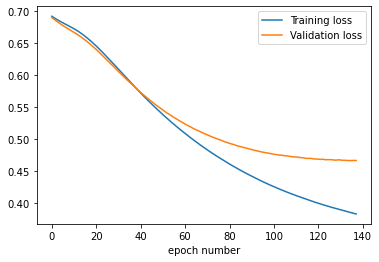

In [28]:
val_loss = history.history['val_loss']
epoch_range = range(len(val_loss))
plt.plot(epoch_range, history.history['loss'], label = 'Training loss')
plt.plot(epoch_range, history.history['val_loss'], label = 'Validation loss')
plt.legend(loc = 'upper right')
plt.xlabel('epoch number')
plt.show()

#### Evaluate on the test data
Achieve an accuracy of about 79% which isn't bad for a first attempt.

In [29]:
model.evaluate(test_padded,
               test_labels,)

48/48 [==============================] - 0s 454us/step - loss: 0.4719 - accuracy: 0.7853


[0.4719289541244507, 0.7852922081947327]

### - Make predictions and submission file -
This is where the submission file is made for the Kaggle competition.

#### Load in and tokenize the test data

In [30]:
submission_test_data = pd.read_csv('test.csv') 
submission_test_sentences = submission_test_data['text'].tolist()

submission_test_sequences = tokeniser.texts_to_sequences(submission_test_sentences) # create tokenised sequences.
submission_test_padded = pad_sequences(submission_test_sequences, 
                       maxlen = max_length, 
                       padding = padding_type, 
                       truncating = trunc_type,)

#### Obtain predictions

In [31]:
new_id = submission_test_data['id']
new_predict = np.round(model.predict(submission_test_padded));

#### Save to file

In [32]:
np.savetxt('submission.csv', np.c_[new_id, new_predict], delimiter = ',', header = 'id,target', comments = '', fmt = '%d')